## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

from src.data import DataLoader
from src.trainer import Trainer
from src.optimizers import SGD
from src.metrics import Accuracy
from src.losses import CrossEntropyLoss

## Data Loading and Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
# Add single dimension for the input channel
X_train = X_train.unsqueeze(1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
# Add single dimension for the input channel
X_val = X_val.unsqueeze(1)
y_val = mnist_testset.targets

train_dataloader = DataLoader(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoader(X_val, y_val, batch_size=256, shuffle=False)

### Single Batch Iteration

In [3]:
in_channels = 1
filter_size = 3 # Filter size for all layers

num_classes = 10

# CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
W1 = nn.Parameter(torch.randn(16, in_channels, filter_size, filter_size) * 0.1)
b1 =  nn.Parameter(torch.zeros(size=(1, 16, 1, 1)))

# CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
W2 = nn.Parameter(torch.randn(32, 16, filter_size, filter_size) * 0.1)
b2 = nn.Parameter(torch.zeros(size=(1, 32, 1, 1)))

# FC Layer (sees 32x7x7 and outputs 32*7*7x10)
W3 = nn.Parameter(torch.randn(32 * 7 * 7, num_classes) * 0.1)
b3 = nn.Parameter(torch.zeros(num_classes))

parameters = [W1, b1, W2, b2, W3, b3]
optimizer = SGD(parameters, lr=0.1)
cross_entropy = CrossEntropyLoss()
padding = (filter_size - 1) // 2

In [5]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
    
        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        Z1 = F.conv2d(inputs, W1, padding=padding) + b1
        A1 = F.relu(Z1)
        P1 = F.max_pool2d(A1, kernel_size=2, stride=2)
    
        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        Z2 = F.conv2d(P1, W2, padding=padding) + b2
        A2 = F.relu(Z2)
        P2 = F.max_pool2d(A2, kernel_size=2, stride=2)
    
        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        P2_flat = P2.flatten(start_dim=1)
        Z3 = P2_flat @ W3 + b3
        y_pred = F.softmax(Z3)
    
        # Calculate Loss
        loss = cross_entropy(y_pred, targets)
    
        # Compute gradients
        loss.backward()
    
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

C:\Users\woute\AppData\Local\Temp\ipykernel_19872\303424511.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(Z3)


0.5362814226049057
0.15864925772902813
0.11597979033881045


### Define Training Loop and Model

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, input_height, input_width, filter_size, num_classes):
        super().__init__()
        self.input_height = input_height
        self.filter_size = filter_size

        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        out_channels1 = 16 # Number of filters in the first conv layer
        self.W1 = nn.Parameter(torch.randn(out_channels1, in_channels, filter_size, filter_size) * 0.1)
        self.b1 =  nn.Parameter(torch.zeros(size=(1, out_channels1, 1, 1)))

        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        out_channels2 = 32 # Number of filters in the second conv layer
        self.W2 = nn.Parameter(torch.randn(out_channels2, out_channels1, filter_size, filter_size) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(size=(1, out_channels2, 1, 1)))

        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        self.W3 = nn.Parameter(torch.randn(out_channels2 * int(input_height/4 * input_width/4), num_classes) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(num_classes))

    def forward(self, X):
        # Forward pass

        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        padding = (self.filter_size - 1) // 2
        Z1 = F.conv2d(X, self.W1, padding=padding) + self.b1
        A1 = F.relu(Z1)
        P1 = F.max_pool2d(A1, kernel_size=2, stride=2)
    
        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        Z2 = F.conv2d(P1, self.W2, padding=padding) + self.b2
        A2 = F.relu(Z2)
        P2 = F.max_pool2d(A2, kernel_size=2, stride=2)
    
        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        P2_flat = P2.flatten(start_dim=1)
        Z3 = P2_flat @ self.W3 + self.b3
        y_pred = F.softmax(Z3)
        return y_pred

    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

C:\Users\woute\AppData\Local\Temp\ipykernel_19872\2405205021.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(Z3)


Epoch 1/10, Training Loss: 0.6443, Validation Loss: 0.2675
Validation accuracy: 0.9197
Epoch 2/10, Training Loss: 0.2279, Validation Loss: 0.1886
Validation accuracy: 0.9396
Epoch 3/10, Training Loss: 0.1647, Validation Loss: 0.1658
Validation accuracy: 0.9497
Epoch 4/10, Training Loss: 0.1319, Validation Loss: 0.1117
Validation accuracy: 0.9659
Epoch 5/10, Training Loss: 0.1115, Validation Loss: 0.1036
Validation accuracy: 0.9680
Epoch 6/10, Training Loss: 0.0988, Validation Loss: 0.0885
Validation accuracy: 0.9736
Epoch 7/10, Training Loss: 0.0892, Validation Loss: 0.0794
Validation accuracy: 0.9745
Epoch 8/10, Training Loss: 0.0818, Validation Loss: 0.0739
Validation accuracy: 0.9768
Epoch 9/10, Training Loss: 0.0762, Validation Loss: 0.0838
Validation accuracy: 0.9740
Epoch 10/10, Training Loss: 0.0720, Validation Loss: 0.0732
Validation accuracy: 0.9765


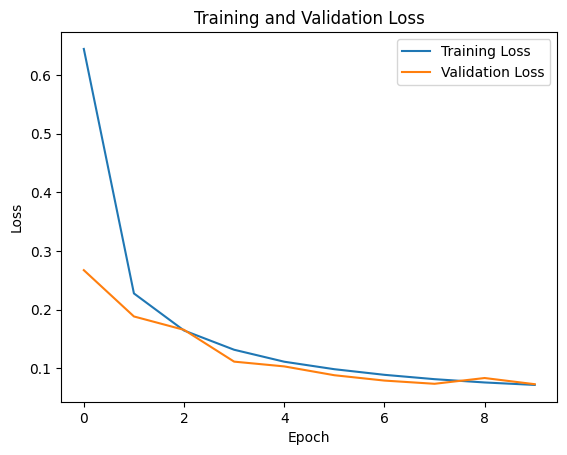

In [7]:
input_height, input_width = 28, 28
in_channels = 1
filter_size = 3 # Filter size for all layers
num_classes = y_train.unique().shape[0]

num_epochs = 10
learning_rate = 0.05

model = CNN(in_channels, input_height, input_width, filter_size, num_classes)
optimizer = SGD(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
metrics = {'accuracy': Accuracy()}
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of CNN

Epoch 1/10, Training Loss: 0.7839, Validation Loss: 0.3192
Validation accuracy: 0.9045
Epoch 2/10, Training Loss: 0.2478, Validation Loss: 0.1882
Validation accuracy: 0.9445
Epoch 3/10, Training Loss: 0.1649, Validation Loss: 0.1395
Validation accuracy: 0.9606
Epoch 4/10, Training Loss: 0.1276, Validation Loss: 0.1027
Validation accuracy: 0.9690
Epoch 5/10, Training Loss: 0.1062, Validation Loss: 0.0973
Validation accuracy: 0.9715
Epoch 6/10, Training Loss: 0.0930, Validation Loss: 0.0826
Validation accuracy: 0.9739
Epoch 7/10, Training Loss: 0.0841, Validation Loss: 0.0730
Validation accuracy: 0.9767
Epoch 8/10, Training Loss: 0.0777, Validation Loss: 0.0799
Validation accuracy: 0.9741
Epoch 9/10, Training Loss: 0.0717, Validation Loss: 0.0655
Validation accuracy: 0.9782
Epoch 10/10, Training Loss: 0.0678, Validation Loss: 0.0645
Validation accuracy: 0.9781


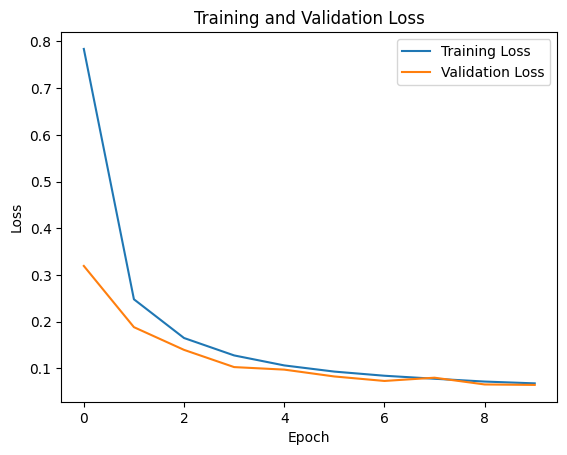

In [ ]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        padding = (3 - 1) // 2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=padding)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        self.fc1 = nn.Linear(32 * 7 * 7, num_classes)


    def forward(self, x):
        # CONV + POOL Layer 1 (sees 1x28x28 and outputs 16x14x14)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # CONV + POOL Layer 2 (sees 16x14x14 and outputs 32x7x7)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # FC Layer (sees 32x7x7 and outputs 32*7*7x10)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)

        return x

num_classes = y_train.unique().shape[0]
model = CNN(num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
metrics = {'accuracy':Accuracy()}
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=10)

In [ ]:
# Assuming the Accuracy class is defined as per your snippet
# Ensure your model, train_loader, and val_loader are defined

# Initialize accuracy trackers
train_accuracy = Accuracy()
val_accuracy = Accuracy()

# Set model to evaluation mode
model.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Calculate training accuracy
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        train_accuracy.update(outputs, labels)
    
    train_acc = train_accuracy.compute()
    train_accuracy.reset()  # Reset for future use if needed

    # Calculate validation accuracy
    for inputs, labels in val_dataloader:
        outputs = model(inputs)
        val_accuracy.update(outputs, labels)
    
    val_acc = val_accuracy.compute()
    val_accuracy.reset()  # Reset for future use if needed

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Training Accuracy: 97.76%
Validation Accuracy: 97.95%
